In [1]:
import numpy as np
from typing import Tuple


def sig1(n1: float, n2: float) -> np.ndarray:
    return np.sin(2 * np.pi * n1 + 3 * np.pi * n2)


def sig2(n1: float, n2: float) -> np.ndarray:
    return np.sin(4 * np.pi * n1) + np.cos(6 * np.pi * n2)


def pixels(width: int, height: int) -> Tuple[np.ndarray, np.ndarray]:
    h_points = np.arange(width)
    v_points = np.arange(height)

    h_coord = np.tile(h_points, (height, 1))
    v_coord = np.tile(np.expand_dims(v_points, axis=0).T, (1, width))

    return h_coord, v_coord


def time1(width: int, height: int) -> np.ndarray:
    h, v = pixels(width, height)
    return sig1(h, v)


def time2(width: int, height: int) -> np.ndarray:
    h, v = pixels(width, height)
    return sig2(h, v)


def freq1(width: int, height: int) -> np.ndarray:
    if min(width, height) <= 5:
        raise ValueError('width, height must be equal or greater than 5')
    Y = np.zeros((width, height))
    Y[0][5] = Y[0][width - 5] = 1.0
    return Y


def freq2(width: int, height: int) -> np.ndarray:
    if min(width, height) <= 5:
        raise ValueError('width, height must be equal or greater than 5')
    Y = np.zeros((width, height))
    Y[5][0] = Y[height - 5][0] = 1.0
    return Y


def freq3(width: int, height: int) -> np.ndarray:
    if min(width, height) <= 5:
        raise ValueError('width, height must be equal or greater than 5')
    Y = np.zeros((width, height))
    Y[5][5] = Y[width - 5][height - 5] = 1.0
    return Y


In [2]:
def freq_to_time(freq: np.ndarray) -> np.ndarray:
    return np.real(np.fft.ifft2(freq))


def time_to_freq(time: np.ndarray) -> np.ndarray:
    return np.fft.fft2(time)


In [3]:
N = 10
width, height = N, N

t1 = time1(width, height)
t2 = time2(width, height)
t3 = None
t4 = None
t5 = None

f1 = None
f2 = None
f3 = freq1(width, height)
f4 = freq2(width, height)
f5 = freq3(width, height)

f1 = time_to_freq(t1)
f2 = time_to_freq(t2)
t3 = freq_to_time(f3)
t4 = freq_to_time(f4)
t5 = freq_to_time(f5)

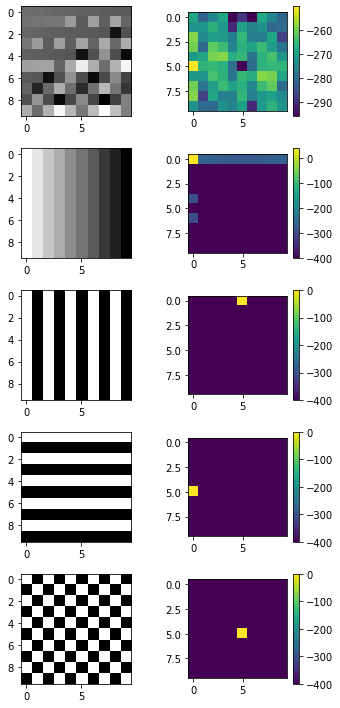

In [4]:
import matplotlib.pyplot as plt

inputs = [
    (t1, f1),
    (t2, f2),
    (t3, f3),
    (t4, f4),
    (t5, f5),
]

fig, axis = plt.subplots(len(inputs), len(inputs[0]), figsize=(5, 10))
fig.tight_layout()

for i, (time, freq) in enumerate(inputs):
    im_time = axis[i][0].imshow(time, cmap='gray')
    im_freq = axis[i][1].imshow(20 * np.log10(np.abs(freq) + 1e-20))
    fig.colorbar(im_freq, ax=axis[i][1])


**Observation**: For the second row shown above, you can notice that
the image shows a grayscale gradient caused by some floating point errors
caused by the sin function.

SNR Threshold = 2.39
Optimum SNR = 2.382995381660462
Initial SNR=2.0737716391704213


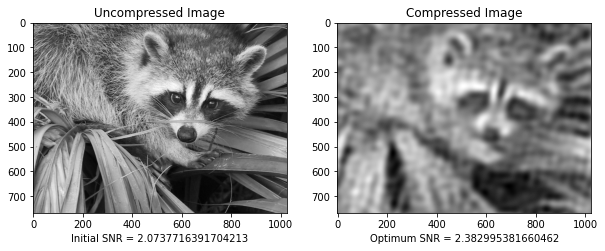

In [5]:
from scipy import misc, ndimage

def snr(signal: np.ndarray):
  mean = np.mean(signal)
  std  = np.std(signal)
  return mean / std

# Load the image in memory
X = misc.face(gray=True)
X_compressed = X

# Set a custom SNR threshold for compression
snr_threshold = 2.39

# Convert to frequency domain
Y = np.fft.fft2(X)
Y_spectrum = np.abs(Y)
Y_coefficients = np.flip(np.sort(Y_spectrum.flatten()))

# Initialize the optimum value
X_optim = X_compressed
interval = np.array((0.0, 1.0))
threshold_previous = -1
threshold_counter = 0

# Find optimum values
while np.abs(snr(X_compressed) - snr_threshold) >= 1e-2:
  threshold = np.mean(interval)

  threshold_index = int(np.min(
      (
        threshold * Y_coefficients.shape[0],
        Y_coefficients.shape[0] - 1
      )
    )
  )

  if threshold_previous == -1:
    threshold_previous = threshold_index

  threshold_value = Y_coefficients[threshold_index]

  compression_mask = Y_spectrum >= threshold_value

  Y_compressed = compression_mask * Y

  X_compressed = np.real(np.fft.ifft2(Y_compressed))

  snr_current = snr(X_compressed)

  if snr_current > snr_threshold:
    interval[0] = threshold
  elif snr_current < snr_threshold:
    interval[1] = threshold
    X_optim = X_compressed

  if threshold_previous == threshold_index:
    threshold_counter += 1
  else:
    threshold_counter = 0

  if threshold_counter >= 10:
    break

  threshold_previous = threshold_index

fig, (uncompressed_axis, compressed_axis) = plt.subplots(1, 2, figsize=(10, 5))

compressed_axis.set_title('Compressed Image')
compressed_axis.set_xlabel(f'Optimum SNR = {snr(X_optim)}')
compressed_axis.imshow(X_optim, cmap=plt.cm.gray)

uncompressed_axis.set_title('Uncompressed Image')
uncompressed_axis.set_xlabel(f'Initial SNR = {snr(X)}')
uncompressed_axis.imshow(X, cmap=plt.cm.gray)

print(f'SNR Threshold = {snr_threshold}')

print(f'Optimum SNR = {snr(X_optim)}')

print(f'Initial SNR={snr(X)}')

plt.show()

In [6]:
from typing import Tuple

def circular_mask(
  sizes: Tuple[float, ...],
  radius: float,
  center: Tuple[float, ...] = None,
  metric = lambda p1, p2: (p1 - p2) ** 2
) -> np.ndarray:
  if center is None:
    center = sizes[0] // 2, sizes[1] // 2

  rows, cols = np.ogrid[:sizes[0], :sizes[1]]

  matrix = np.sqrt(metric(rows, center[0]) + metric(cols, center[1]))

  return matrix <= radius

Noisy Image SNR = 0.89
Denoised Image SNR = 2.12


f:\university\proc-semnale\signals-processing\venv\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log10


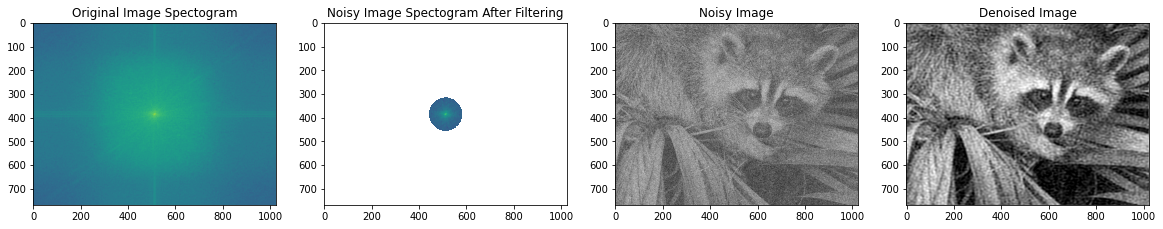

In [7]:
from scipy import signal

# Load image and add noise
pixel_noise = 200
noise = np.random.randint(-pixel_noise, high=pixel_noise+1, size=X.shape)
X_noisy = X + noise

# Compute the FFT
Y_original = np.fft.fft2(X)
Y_noisy = np.fft.fft2(X_noisy)

# Shift the values to the center
Y_original_shift = np.fft.fftshift(Y_original)
Y_noisy_shift = np.fft.fftshift(Y_noisy)

# Calculate the magnitudes
Y_original_magnitude = np.abs(Y_original_shift.copy())

# Create a bidimensional gaussian window, to smooth the noise present in the
# image, which will add a bit of blur. Also create a circular mask to remove
# the noise surrounding the image signal.
std = 75
gauss_filter_v = signal.windows.gaussian(Y_noisy.shape[0], std)
gauss_filter_h = signal.windows.gaussian(Y_noisy.shape[1], std)
gauss_filter = np.sqrt(np.outer(gauss_filter_v, gauss_filter_h))
gauss_filter = gauss_filter * circular_mask(gauss_filter.shape, 75)
Y_noisy_shift = Y_noisy_shift * gauss_filter

# Create spectograms useful for viewing the results
Y_noisy_magnitude = np.abs(Y_noisy_shift.copy())
Y_original_magnitude = np.abs(Y_original_shift.copy())

# Shift back the values
Y_original_processed = np.fft.ifftshift(Y_original_shift)
Y_noisy_processed = np.fft.ifftshift(Y_noisy_shift)

# Transform back to images
X_initial = np.real(np.fft.ifft2(Y_original_processed))
X_cleaned = np.real(np.fft.ifft2(Y_noisy_processed))
X_cleaned = np.clip(X_cleaned.round(), 0, 255)

# Plot the images and results
fig, (
  original_spectrum_axis,
  noisy_spectrum_axis,
  noisy_image_axis,
  cleaned_image_axis,
) = plt.subplots(1, 4, figsize=(20, 10))

# Compare the noise SNR and denoised SNR
print(
  f'Noisy Image SNR = {snr(X_noisy):.2f}',
  f'Denoised Image SNR = {snr(X_cleaned):.2f}',
  sep='\n'
)

# Show the results
original_spectrum_axis.imshow(20 * np.log10(Y_original_magnitude))
original_spectrum_axis.set_title('Original Image Spectogram')

noisy_spectrum_axis.imshow(20 * np.log10(Y_noisy_magnitude))
noisy_spectrum_axis.set_title('Noisy Image Spectogram After Filtering')

noisy_image_axis.imshow(X_noisy, cmap=plt.cm.gray)
noisy_image_axis.set_title('Noisy Image')

cleaned_image_axis.imshow(X_cleaned, cmap=plt.cm.gray)
cleaned_image_axis.set_title('Denoised Image')

plt.show()

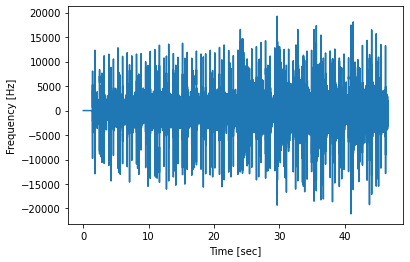

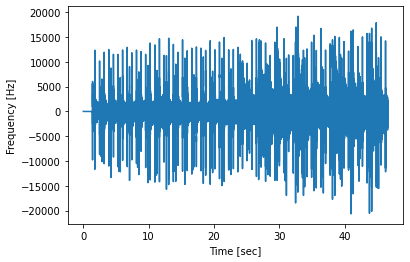

In [395]:
# Load the music using a custom library
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np

# Files
src = "./resources/music.mp3"
dst = "./resources/music_wav.wav"
pro = "./resources/music_proc.wav"

# Convert wav to mp3
sound = AudioSegment.from_mp3(src)
sound.export(dst, format="wav")

# Generate X-Axis Values
sample_rate, samples = wavfile.read('./resources/music_wav.wav')
time_array = np.linspace(0, samples.shape[0]/sample_rate, samples.shape[0])

# First channel
plt.plot(time_array, samples[:, 0])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Second channel
plt.plot(time_array, samples[:, 1])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

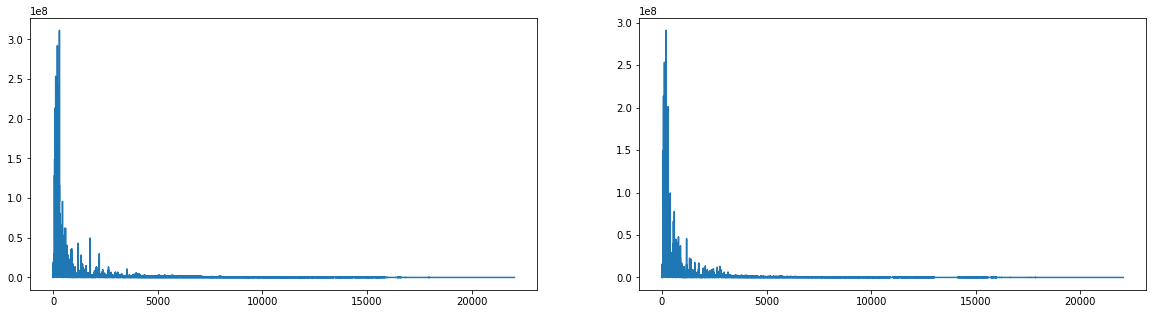

In [396]:
# Compute FFT over the sound
sound_chan1 = samples[:, 0]
sound_chan2 = samples[:, 1]

sound_chan1_fft = np.fft.fft(sound_chan1)
sound_chan2_fft = np.fft.fft(sound_chan2)

sound_chan1_spec = np.abs(sound_chan1_fft)
sound_chan2_spec = np.abs(sound_chan2_fft)

size = sound_chan1_spec.shape[0]
half = sound_chan1_spec.shape[0]//2

# Calculate FFT sample frequencies
frequencies = np.fft.fftfreq(size, d=1.0/sample_rate)

# Plot FFT spectrum
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(frequencies[:half], sound_chan1_spec[:half])
axis[1].plot(frequencies[:half], sound_chan2_spec[:half])
plt.show()

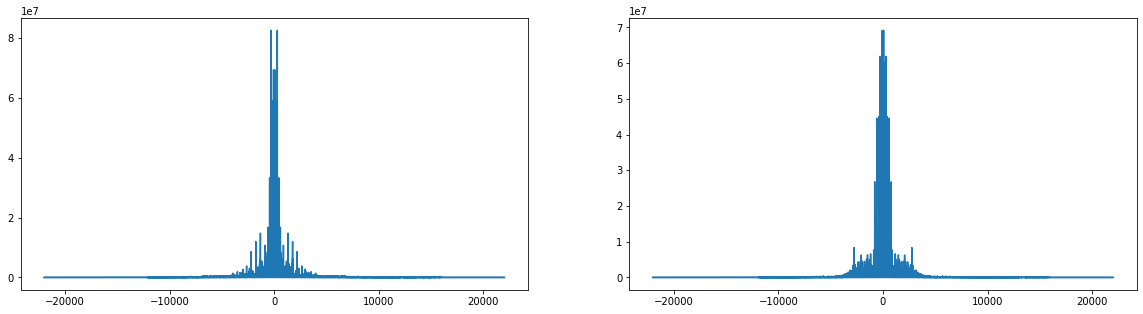

In [404]:
from scipy import signal

# Process the sound
interval = np.array(((25, 30)))
interval = interval * sample_rate
time_array.shape[0] / sample_rate

# Select a range from the song
sound_chan1_interval = sound_chan1[interval[0]:interval[1]]
sound_chan2_interval = sound_chan2[interval[0]:interval[1]]

# Compute the FFT Transform
sound_chan1_int_fft = np.fft.fft(sound_chan1_interval)
sound_chan2_int_fft = np.fft.fft(sound_chan2_interval)

# Compute the spectrum
sound_chan1_int_spec = np.abs(sound_chan1_int_fft)
sound_chan2_int_spec = np.abs(sound_chan2_int_fft)

# Plot FFT spectrums
length = interval[1] - interval[0]
half = length // 2

# Calculate FFT sample frequencies
frequencies = np.fft.fftfreq(length, d=1.0/sample_rate)

# Plot FFT spectrum
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(frequencies, sound_chan1_int_spec)
axis[1].plot(frequencies, sound_chan2_int_spec)
plt.show()

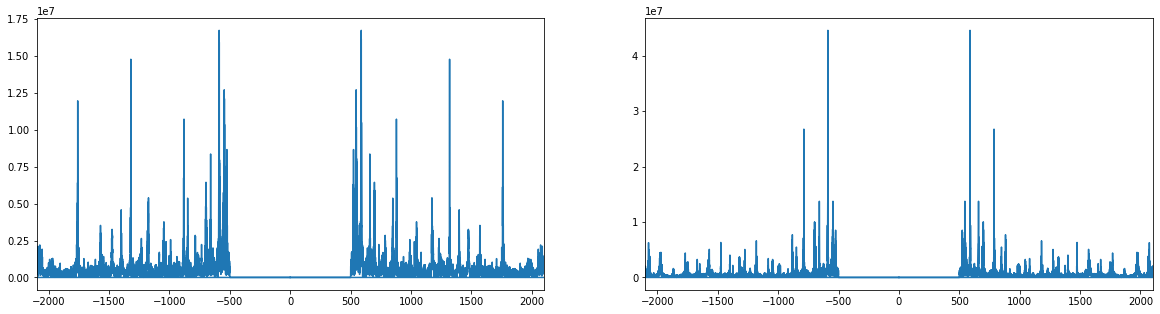

In [408]:
# Create bandstop interval
bandstop = np.array((0, 500))

sound_chan1_int_fft_filt = sound_chan1_int_fft.copy()
sound_chan2_int_fft_filt = sound_chan2_int_fft.copy()

sound_chan1_int_fft_filt[
  (frequencies >=  bandstop[0]) & (frequencies <=  bandstop[1]) |
  (frequencies <= -bandstop[0]) & (frequencies >= -bandstop[1])
] = 0.0

sound_chan2_int_fft_filt[
  (frequencies >=  bandstop[0]) & (frequencies <=  bandstop[1]) |
  (frequencies <= -bandstop[0]) & (frequencies >= -bandstop[1])
] = 0.0

# Plot FFT spectrum
lowpass = 2_100
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(frequencies, np.abs(sound_chan1_int_fft_filt))
axis[1].plot(frequencies, np.abs(sound_chan2_int_fft_filt))
axis[0].set_xlim([-lowpass, lowpass])
axis[1].set_xlim([-lowpass, lowpass])
plt.show()

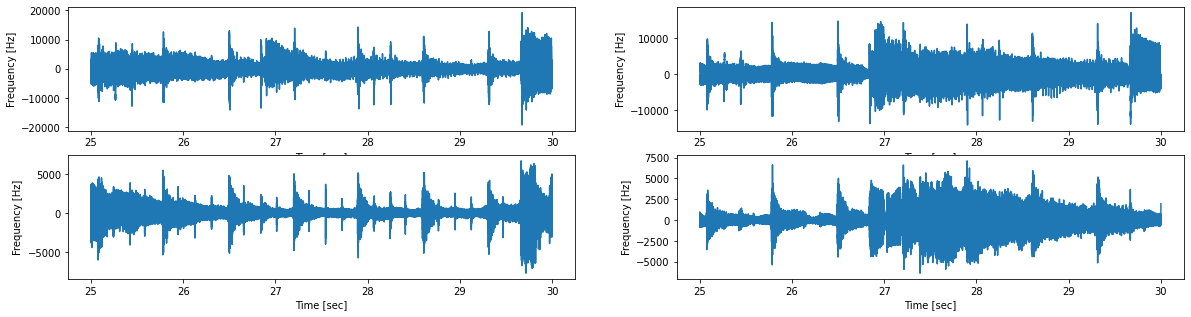

In [409]:
sound_chan1_int_proc = np.real(np.fft.ifft(sound_chan1_int_fft_filt))
sound_chan2_int_proc = np.real(np.fft.ifft(sound_chan2_int_fft_filt))

# Modified sound interval
fig, axis = plt.subplots(2, 2, figsize=(20, 5))

# Before
# First channel
axis[0][0].plot(time_array[interval[0]:interval[1]], sound_chan1[interval[0]:interval[1]])
axis[0][0].set_ylabel('Frequency [Hz]')
axis[0][0].set_xlabel('Time [sec]')

# Second channel
axis[0][1].plot(time_array[interval[0]:interval[1]], sound_chan2[interval[0]:interval[1]])
axis[0][1].set_ylabel('Frequency [Hz]')
axis[0][1].set_xlabel('Time [sec]')

# After
# First channel
axis[1][0].plot(time_array[interval[0]:interval[1]], sound_chan1_int_proc)
axis[1][0].set_ylabel('Frequency [Hz]')
axis[1][0].set_xlabel('Time [sec]')

# Second channel
axis[1][1].plot(time_array[interval[0]:interval[1]], sound_chan2_int_proc)
axis[1][1].set_ylabel('Frequency [Hz]')
axis[1][1].set_xlabel('Time [sec]')
plt.show()

In [410]:

# Zero a component (manual, using window, or intensity)
output_sound = np.stack(
  (
    sound_chan1_int_proc,
    sound_chan2_int_proc
  ),
  axis=1
)

print(output_sound)

# Save the result
wavfile.write(pro, sample_rate, output_sound.astype(np.int16))

[[-930.12798677  940.31183852]
 [-350.46380092  865.83045999]
 [ 188.23750029  776.25389712]
 ...
 [-884.34281822 1634.93167247]
 [-442.5254128  1804.48770357]
 [  65.19923238 1950.57271747]]


In [118]:
# Go back to time domain
sound_chan1_processed = np.real(np.fft.ifft(sound_chan1_fft))
sound_chan2_processed = np.real(np.fft.ifft(sound_chan2_fft))

# Zero a component (manual, using window, or intensity)
output_sound = np.stack(
  (
    sound_chan1_processed,
    sound_chan2_processed
  ),
  axis=1
)

# Save the result
wavfile.write(pro, sample_rate, output_sound.astype(np.int16))